In [1]:
%env CUDA_VISIBLE_DEVICES=-1
import sys
sys.path.append('/home/airplaneless/source/Skoltech/CIG/k-space-mri')
import numpy as np
import pylab as plt
import pickle
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F

# from k_space_reconstruction.utils.metrics import pt_msssim, pt_ssim
from k_space_reconstruction.datasets.acdc import ACDCSet, ACDCTransform, RandomMaskFunc
from k_space_reconstruction.datasets.fastmri import FastMRIh5Dataset, FastMRITransform, LegacyFastMRIh5Dataset
from k_space_reconstruction.utils.kspace import EquispacedMaskFunc, RandomMaskFunc
from k_space_reconstruction.utils.kspace import pt_spatial2kspace as Ft
from k_space_reconstruction.utils.kspace import pt_kspace2spatial as IFt

import os
import sys
from k_space_reconstruction.nets.unet import Unet
from k_space_reconstruction.nets.enet import ENet
from k_space_reconstruction.nets.mwcnn import MWCNN
import datetime
import torch
import torchvision
import numpy as np
import pylab as plt
plt.style.use('bmh')
import albumentations
import numpy as np
import h5py
import pylab as plt
import torch
import torch.nn.functional as F

import os
import re
import numpy as np
import pandas as pd
import nibabel

import torch
import torch.utils.data
import torchvision.transforms as transforms

from os.path import isdir, join
from typing import Callable, Dict, List, Any

env: CUDA_VISIBLE_DEVICES=-1


In [2]:
import pytorch_lightning as pl


class BraTSClassifierBinary(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.net = torchvision.models.resnet18()
        self.net.conv1 = torch.nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.net.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)
        self.register_buffer('sampling', torch.ones(1, 4, 240, 1))
        self.use_sampling = False

    @staticmethod
    def _to_pred(logits):
        return logits.argmax(1)

    def predict(self, batch):
        logits = self(batch)
        return self._to_pred(logits)

    def forward(self, batch):
        if self.use_sampling:
            ks = Ft(batch['image'] * batch['std'] + batch['mean']) * self.sampling
            images = (IFt(ks).abs() - batch['mean']) / (batch['std'] + 1e-11)
            return self.net(images)
        else:
            return self.net(batch['image'])

    def training_step(self, batch, batch_idx):
        y = self(batch)
        loss = F.cross_entropy(y, batch['target'])
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        y = self(batch)
        loss = F.cross_entropy(y, batch['target'])
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, self.parameters()))
        return optimizer

In [3]:
brats_class_map = {0: 'WT', 1: 'TC', 2: 'ET'}
brats_image_map = {0: 'T1', 1: 'T2', 2: 'T1ce', 3: 'FLAIR'}

def dice_coeff_3d_classes(true, logits, eps=1e-11):
    num_classes = logits.shape[0]
    probas = torch.nn.functional.softmax(logits, dim=0)
    probas[probas > 0.5] = 1
    probas[probas <= 0.5] = 0
    pmask = torch.zeros_like(true).float()
    for i in range(1, num_classes): pmask[0] += probas[i] * i
    dice_ls = []
    for i in range(1, num_classes):
        true_1_hot = (true>=i).float().flatten()
        pred_1_hot = (pmask>=i).float().flatten()
        intersection = torch.sum(pred_1_hot * true_1_hot)
        cardinality = torch.sum(pred_1_hot + true_1_hot)
        dice_ls.append((2. * intersection / (cardinality + eps)).item())
    return dice_ls


class BraTS3dDataset(torch.utils.data.Dataset):

    def __init__(self, hf_path: str, aug=None, indexes=None):
        super().__init__()
        self.hf = h5py.File(hf_path)
        self.aug = aug

    def __len__(self) -> int:
        return len(self.hf)
    
    def __getitem__(self, item: int):
        img = self.hf[str(item)][:-1,:,:,:]
        mask = self.hf[str(item)][-1:,:,:,:]
        mask[mask==4] = 3
        if self.aug:
            aug = self.aug(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']
        img = torch.tensor(img).float()
        img = img.movedim(3,1)
        ks = Ft(img)
        mask = torch.tensor(mask).long()
        mask = mask.movedim(3,1)
        mean = img.mean(dim=(2,3)).unsqueeze(2).unsqueeze(2)
        std = img.std(dim=(2,3)).unsqueeze(2).unsqueeze(2)
        return img, ks, mask, (img - mean) / (std + 1e-11)

In [4]:
def t2i(x):
    x = x - x.min()
    x = x / x.max()
    x = x * 255.
    return x

def _pt_ssim(pred, gt):
    from pytorch_msssim import ssim
    return ssim(t2i(pred), t2i(gt), win_size=11)

def pt_ssim(pred, gt):
    from pytorch_msssim import ssim
    return ssim(t2i(pred)[None], t2i(gt)[None], win_size=11)

def ssim_score(pred, gt):
    from k_space_reconstruction.utils.metrics import ssim
    return ssim(pred.cpu().numpy(), gt.cpu().numpy())

def pt_msssim(pred, gt):
    from pytorch_msssim import ms_ssim
    return ms_ssim(t2i(pred)[None], t2i(gt)[None])

def pt_nmse(pred, gt):
    pred = t2i(pred)
    gt = t2i(gt)
    return torch.norm(gt - pred, p=2) ** 2 / torch.norm(gt, p=2) ** 2

def pt_psnr(pred, gt):
    pred = t2i(pred)
    gt = t2i(gt)
    maxval = gt.max()
    mse = torch.mean((pred - gt) ** 2)
    return 20 * torch.log10(maxval / torch.sqrt(mse))

In [5]:
train_3d_dataset = BraTS3dDataset('/run/media/airplaneless/Backup/DATA/brats_h5/train.h5')
val_3d_dataset = BraTS3dDataset('/run/media/airplaneless/Backup/DATA/brats_h5/val.h5')

In [6]:
np.random.seed(42)
torch.manual_seed(42)

model = Unet(4, 4).train(False).eval()
model.load_state_dict(torch.load('./brats/unet-brats-norot-3.pt', map_location='cpu'))

resnet = BraTSClassifierBinary\
.load_from_checkpoint('./classification-brats/logs/BraTSClassifierBinary/epoch=03-val_loss=0.238.ckpt')\
.eval().net

In [7]:
w_recon = torch.load('./brats-zf-recon/sampling_igs.pt', map_location='cpu')
w_clf = torch.load('./classification-brats/samplings_bce.pt', map_location='cpu')[-3]
w_seg = torch.load('./brats/sampling_igs.pt', map_location='cpu')

In [8]:
w_clf.sum() / 4, w_recon.sum() / 4, w_seg.sum() / 4

(tensor(16.), tensor(16.), tensor(16.))

In [9]:
@torch.no_grad()
def predict(model, img):
    mean = img.mean()
    std = img.std()
    return model(((img - mean) / (std + 1e-11)).movedim(0, 1)).movedim(0, 1)

@torch.no_grad()
def classify(model, img):
    mean = img.mean()
    std = img.std()
    return model(((img - mean) / (std + 1e-11))[None])[0]

In [10]:
C = 3
N = 102
displ = 1

img, ks, mask, _ = val_3d_dataset[64]
img = img[C,N][displ:-displ,displ:-displ]
_img_recon = IFt(ks * w_recon.unsqueeze(2).unsqueeze(1).cpu()).abs()
img_recon = _img_recon[C,N][displ:-displ,displ:-displ]
_img_clf = IFt(ks * w_clf.unsqueeze(2).unsqueeze(1).cpu()).abs()
img_clf = _img_clf[C,N][displ:-displ,displ:-displ]
_img_seg = IFt(ks * w_seg.unsqueeze(2).unsqueeze(1).cpu()).abs()
img_seg = _img_seg[C,N][displ:-displ,displ:-displ]

yp_recon = predict(model, _img_recon)
cls_recon = classify(resnet, _img_recon[:, N]).softmax(0)
yp_clf = predict(model, _img_clf)
cls_clf = classify(resnet, _img_clf[:, N]).softmax(0)
yp_seg = predict(model, _img_seg)
cls_seg = classify(resnet, _img_seg[:, N]).softmax(0)


def get_scores(pred, gt, yp_sg, mask_sg, cls_sg):
    print(pred.shape)
    displ = 50
    pred = pred[displ:-displ,displ:-displ]
    gt = gt[displ:-displ,displ:-displ]
    ssim_val = pt_ssim(pred[None], gt[None]).item()
    psnr_val = pt_psnr(pred, gt).item()
    nmse_val = pt_nmse(pred, gt).item()
    dice_wt, dice_tc, dice_et = dice_coeff_3d_classes(mask_sg, yp_sg)
    return 'SSIM: %.4f\nPSNR: %.3f\nNMSE: %.4f\nWTdice: %.3f\nTCdice: %.3f\nETdice: %.3f\nIsTumor: %.3f' % (
        ssim_val, psnr_val, nmse_val, dice_wt, dice_tc, dice_et, cls_sg[-1].item()
    )

def logit2mask(yp):
    probas = F.softmax(yp, dim=0)
    probas = (probas > 0.5).long()
    pmask = torch.zeros_like(mask)
    pmask[0] = probas[1] * 1 + probas[2] * 2 + probas[3] * 3
    return pmask

def w2sampling(_w):
    ssm = torch.zeros(240, 240)
    for i in range(4):
        ssm[:, 60*i:60*(i+1)] = _w[i][:, None]
        # ssm[60*i:60*(i+1)] = _w[i]
    return ssm

/home/airplaneless/miniconda3/envs/pytorch_p38/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([238, 238])
torch.Size([238, 238])
torch.Size([238, 238])


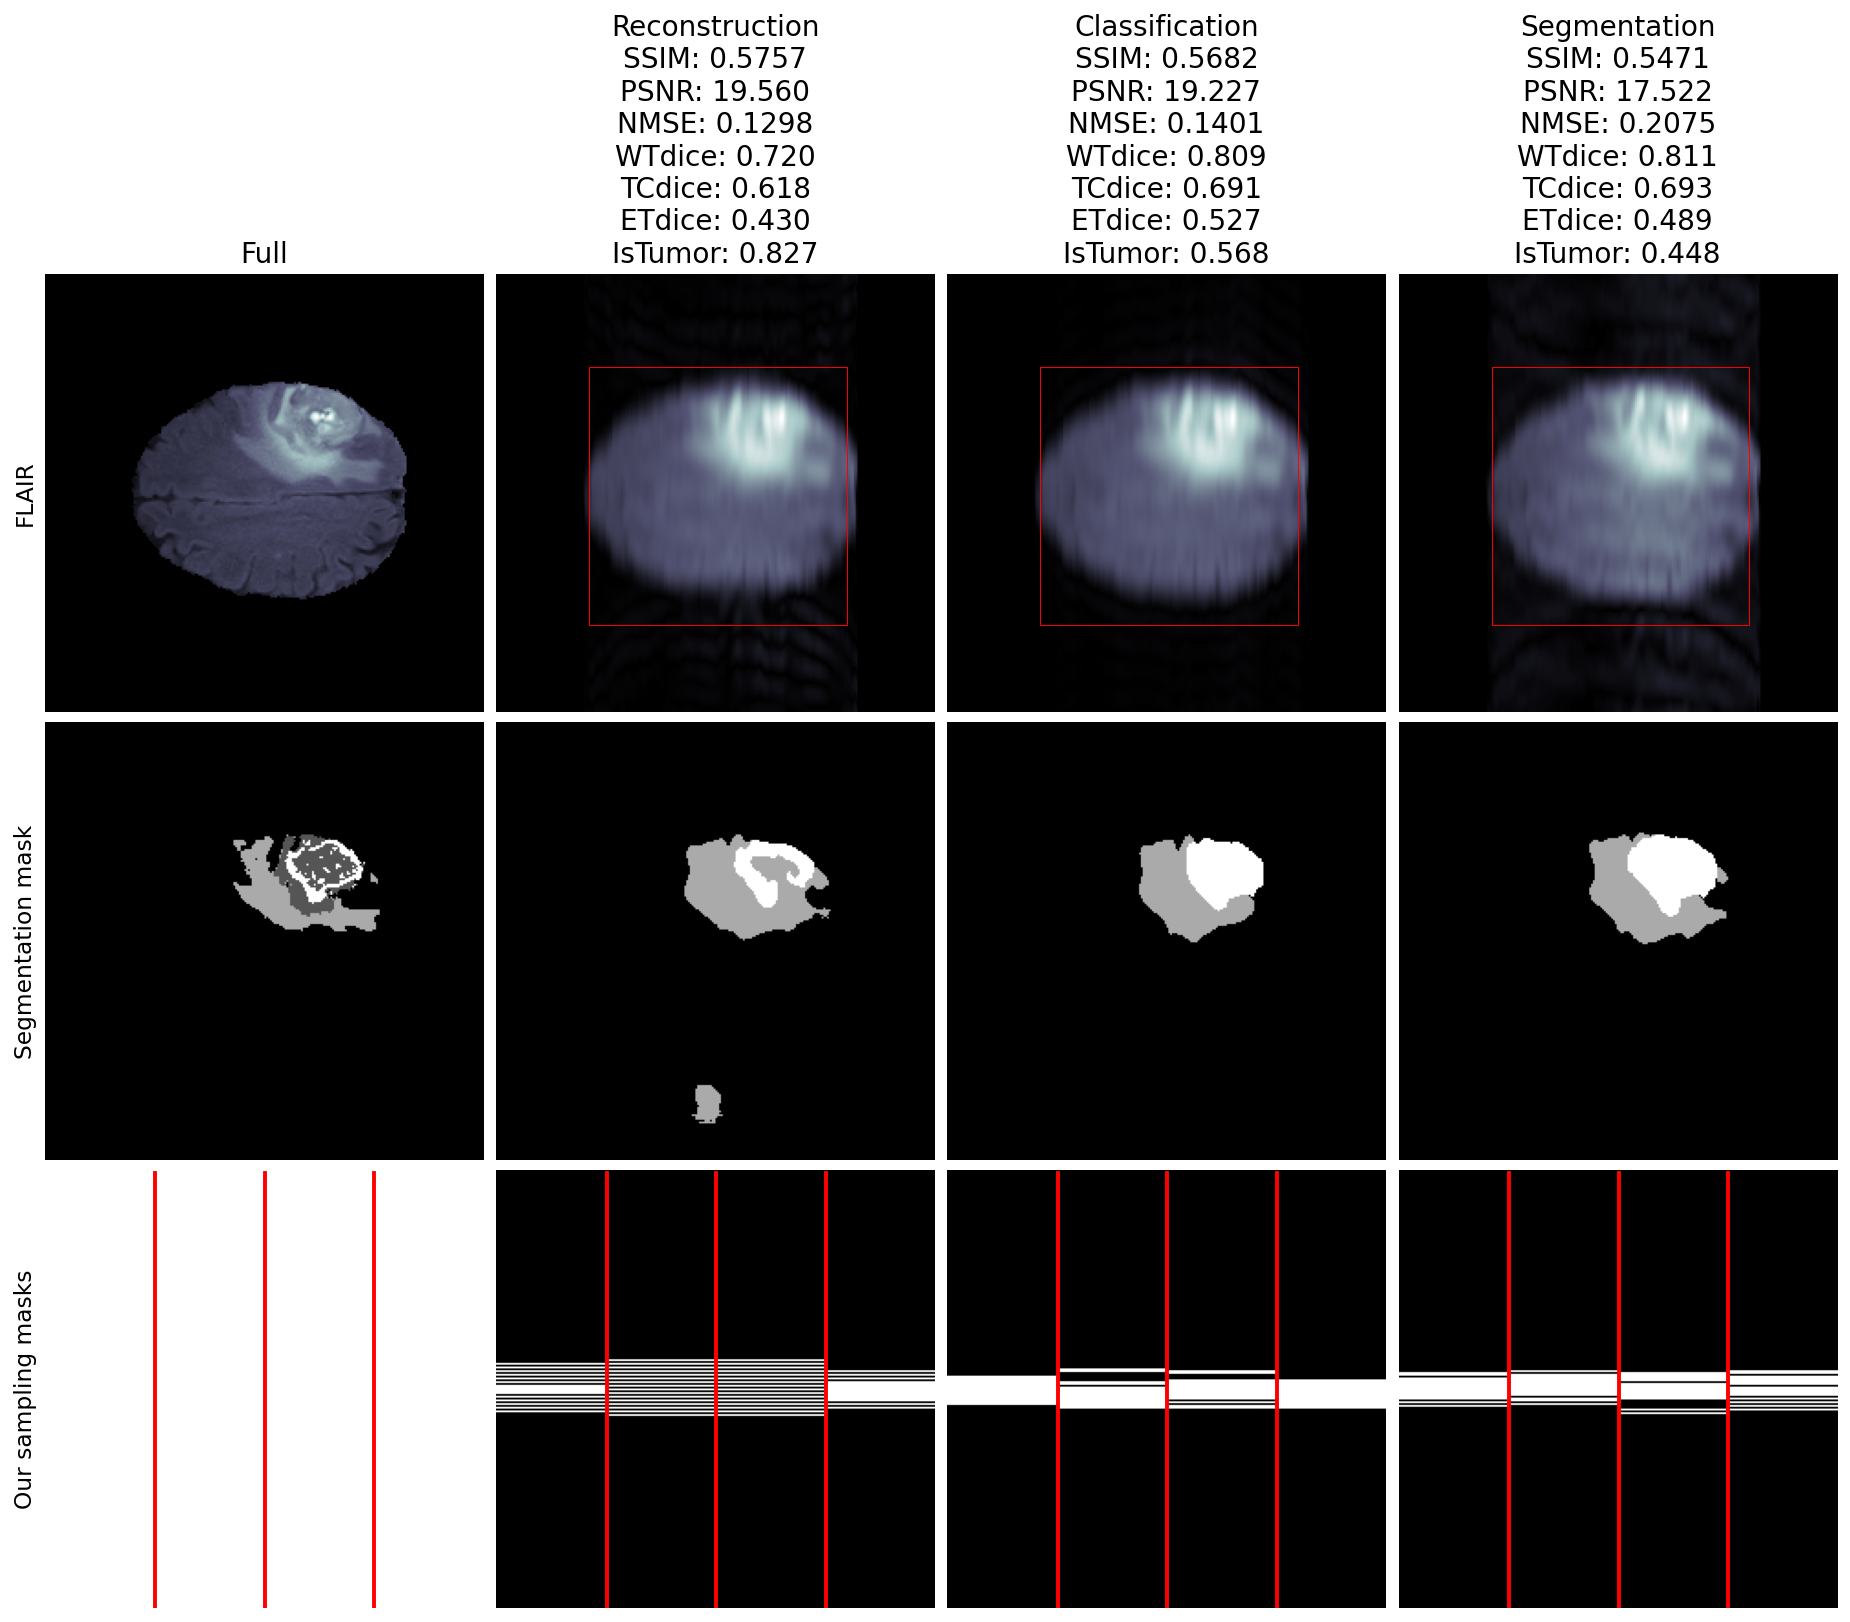

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(8*1.6,6*1.6), dpi=140, subplot_kw=dict(frameon=False, xticks=[], yticks=[]), gridspec_kw=None)

ax[0,0].imshow(img, cmap=plt.cm.bone)
ax[0,0].set_title('Full')
ax[0,1].imshow(img_recon, cmap=plt.cm.bone)
ax[0,1].add_patch(plt.matplotlib.patches.Rectangle((50, 50), 140, 140, linewidth=0.5, edgecolor='r', facecolor='none'))
scores = get_scores(img_recon, img, yp_recon, mask, cls_recon)
ax[0,1].set_title('Reconstruction\n' + scores)
ax[0,2].imshow(img_clf, cmap=plt.cm.bone)
ax[0,2].add_patch(plt.matplotlib.patches.Rectangle((50, 50), 140, 140, linewidth=0.5, edgecolor='r', facecolor='none'))
scores = get_scores(img_clf, img, yp_clf, mask, cls_clf)
ax[0,2].set_title('Classification\n' + scores)
ax[0,3].imshow(img_seg, cmap=plt.cm.bone)
ax[0,3].add_patch(plt.matplotlib.patches.Rectangle((50, 50), 140, 140, linewidth=0.5, edgecolor='r', facecolor='none'))
scores = get_scores(img_seg, img, yp_seg, mask, cls_seg)
ax[0,3].set_title('Segmentation\n' + scores)

ax[1,0].imshow(mask[0, N], cmap=plt.cm.binary_r)
ax[1,1].imshow(logit2mask(yp_recon)[0, N], cmap=plt.cm.binary_r)
ax[1,2].imshow(logit2mask(yp_clf)[0, N], cmap=plt.cm.binary_r)
ax[1,3].imshow(logit2mask(yp_seg)[0, N], cmap=plt.cm.binary_r)

ax[2,0].imshow(torch.ones(240,240), cmap=plt.cm.binary)
ax[2,1].imshow(w2sampling(w_recon), cmap=plt.cm.binary_r)
ax[2,2].imshow(w2sampling(w_clf), cmap=plt.cm.binary_r)
ax[2,3].imshow(w2sampling(w_seg), cmap=plt.cm.binary_r)

for i in range(4):
    for j in range(3):
        ax[2,i].plot([60*(j+1),60*(j+1)],[1,239], 'r')

ax[0,0].set_ylabel(brats_image_map[C])
ax[1,0].set_ylabel('Segmentation mask')
ax[2,0].set_ylabel('Our sampling masks')

fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.03, hspace=0)
plt.savefig('brats-gallery.eps', bbox_inches = "tight")
plt.show()

torch.Size([238, 238])
torch.Size([238, 238])
torch.Size([238, 238])


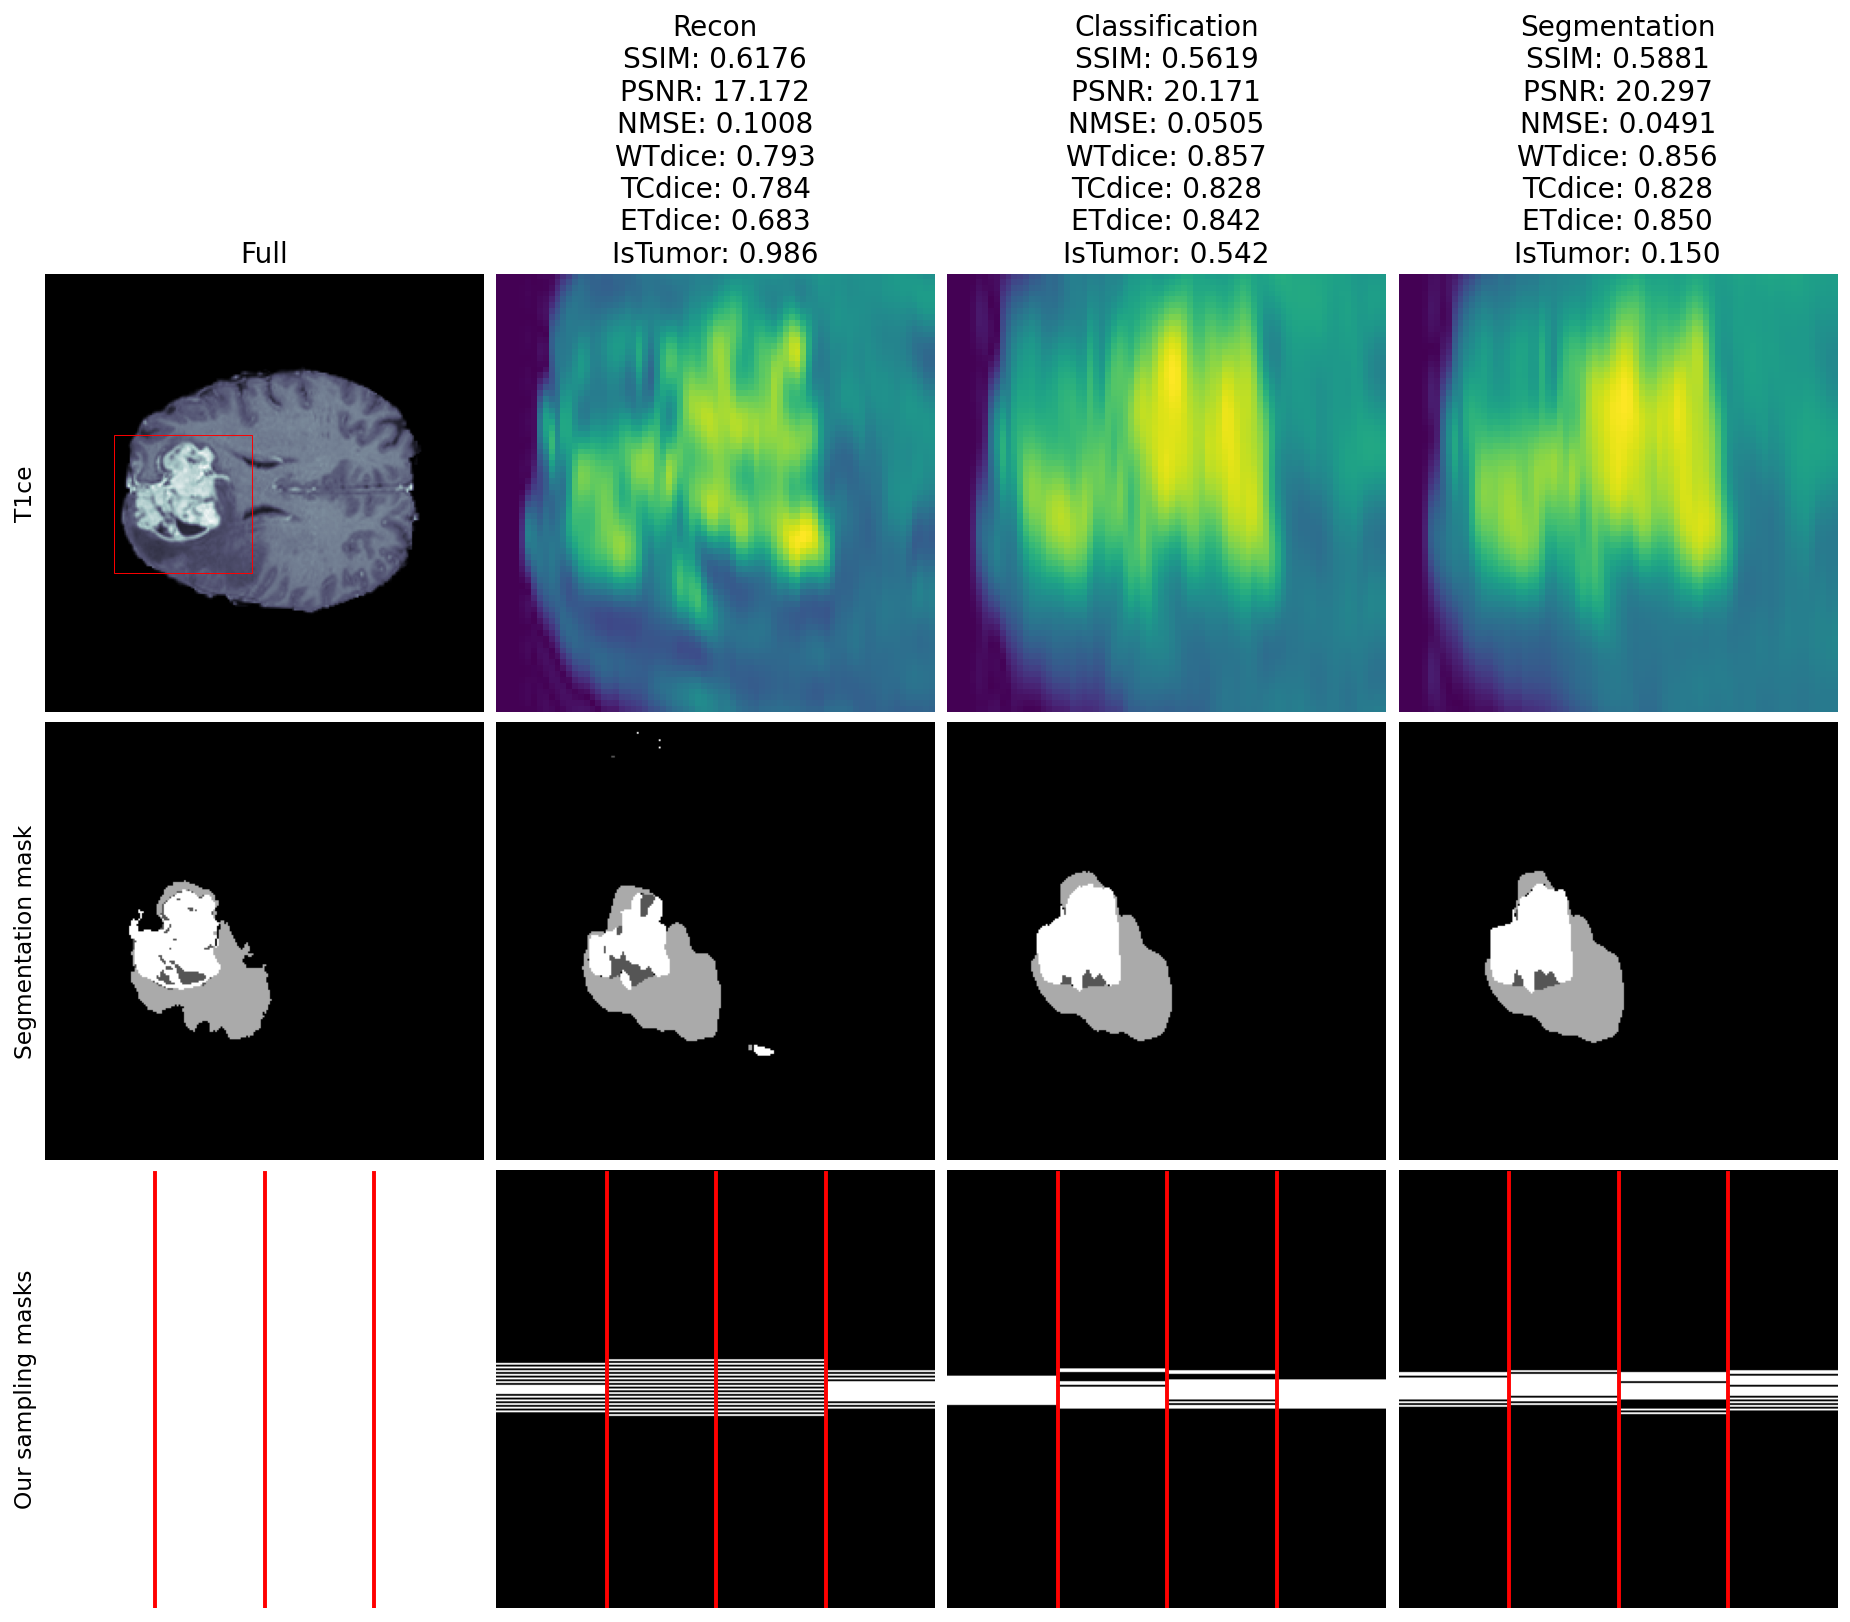

In [35]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(8*1.6,6*1.6), dpi=140, subplot_kw=dict(frameon=False, xticks=[], yticks=[]), gridspec_kw=None)

ax[0,0].imshow(img, cmap=plt.cm.bone)
ax[0,0].set_title('Full')
# im = plt.matplotlib.offsetbox.OffsetImage(ax[0,0].images[0].get_array().data[30:30+39,62:62+44], zoom=2.6)
rect = plt.matplotlib.patches.Rectangle((37, 87), 75, 75, linewidth=0.5, edgecolor='r', facecolor='none')
# im.image.axes = ax[0,0]
# ab = plt.matplotlib.offsetbox.AnnotationBbox(
#     im, (0, 0),
#     xybox=(60., 53.5),
#     pad=0.2,
#     frameon=False,
# )
# ax[0,0].add_artist(ab)
ax[0,0].add_patch(rect)

ax[0,1].imshow(img_recon[87:87+75,37:37+75], cmap=plt.cm.viridis)
# ax[0,1].add_patch(plt.matplotlib.patches.Rectangle((50, 50), 140, 140, linewidth=0.5, edgecolor='r', facecolor='none'))
scores = get_scores(img_recon, img, yp_recon, mask, cls_recon)
ax[0,1].set_title('Recon\n' + scores)

ax[0,2].imshow(img_clf[87:87+75,37:37+75], cmap=plt.cm.viridis)
# ax[0,2].add_patch(plt.matplotlib.patches.Rectangle((50, 50), 140, 140, linewidth=0.5, edgecolor='r', facecolor='none'))
scores = get_scores(img_clf, img, yp_clf, mask, cls_clf)
ax[0,2].set_title('Classification\n' + scores)

ax[0,3].imshow(img_seg[87:87+75,37:37+75], cmap=plt.cm.viridis)
# ax[0,3].add_patch(plt.matplotlib.patches.Rectangle((50, 50), 140, 140, linewidth=0.5, edgecolor='r', facecolor='none'))
scores = get_scores(img_seg, img, yp_seg, mask, cls_seg)
ax[0,3].set_title('Segmentation\n' + scores)

ax[1,0].imshow(mask[0, N], cmap=plt.cm.binary_r)
ax[1,1].imshow(logit2mask(yp_recon)[0, N], cmap=plt.cm.binary_r)
ax[1,2].imshow(logit2mask(yp_clf)[0, N], cmap=plt.cm.binary_r)
ax[1,3].imshow(logit2mask(yp_seg)[0, N], cmap=plt.cm.binary_r)

ax[2,0].imshow(torch.ones(240,240), cmap=plt.cm.binary)
ax[2,1].imshow(w2sampling(w_recon), cmap=plt.cm.binary_r)
ax[2,2].imshow(w2sampling(w_clf), cmap=plt.cm.binary_r)
ax[2,3].imshow(w2sampling(w_seg), cmap=plt.cm.binary_r)

for i in range(4):
    for j in range(3):
        ax[2,i].plot([60*(j+1),60*(j+1)],[1,239], 'r')

ax[0,0].set_ylabel(brats_image_map[C])
ax[1,0].set_ylabel('Segmentation mask')
ax[2,0].set_ylabel('Our sampling masks')

fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.03, hspace=0)
plt.savefig('brats-gallery-v2-ex1.eps', bbox_inches = "tight")
plt.show()

In [12]:
C = 2
N = 80
displ = 1

img, ks, mask, _ = val_3d_dataset[110]
img = img[C,N][displ:-displ,displ:-displ]
_img_recon = IFt(ks * w_recon.unsqueeze(2).unsqueeze(1).cpu()).abs()
img_recon = _img_recon[C,N][displ:-displ,displ:-displ]
_img_clf = IFt(ks * w_clf.unsqueeze(2).unsqueeze(1).cpu()).abs()
img_clf = _img_clf[C,N][displ:-displ,displ:-displ]
_img_seg = IFt(ks * w_seg.unsqueeze(2).unsqueeze(1).cpu()).abs()
img_seg = _img_seg[C,N][displ:-displ,displ:-displ]

yp_recon = predict(model, _img_recon)
cls_recon = classify(resnet, _img_recon[:, N]).softmax(0)
yp_clf = predict(model, _img_clf)
cls_clf = classify(resnet, _img_clf[:, N]).softmax(0)
yp_seg = predict(model, _img_seg)
cls_seg = classify(resnet, _img_seg[:, N]).softmax(0)


def get_scores(pred, gt, yp_sg, mask_sg, cls_sg):
    print(pred.shape)
    displ = 50
    pred = pred[displ:-displ,displ:-displ]
    gt = gt[displ:-displ,displ:-displ]
    ssim_val = pt_ssim(pred[None], gt[None]).item()
    psnr_val = pt_psnr(pred, gt).item()
    nmse_val = pt_nmse(pred, gt).item()
    dice_wt, dice_tc, dice_et = dice_coeff_3d_classes(mask_sg, yp_sg)
    return 'SSIM: %.4f\nPSNR: %.3f\nNMSE: %.4f\nWTdice: %.3f\nTCdice: %.3f\nETdice: %.3f\nIsTumor: %.3f' % (
        ssim_val, psnr_val, nmse_val, dice_wt, dice_tc, dice_et, cls_sg[-1].item()
    )

def logit2mask(yp):
    probas = F.softmax(yp, dim=0)
    probas = (probas > 0.5).long()
    pmask = torch.zeros_like(mask)
    pmask[0] = probas[1] * 1 + probas[2] * 2 + probas[3] * 3
    return pmask

def w2sampling(_w):
    ssm = torch.zeros(240, 240)
    for i in range(4):
        ssm[:, 60*i:60*(i+1)] = _w[i][:, None]
        # ssm[60*i:60*(i+1)] = _w[i]
    return ssm

torch.Size([238, 238])
torch.Size([238, 238])
torch.Size([238, 238])


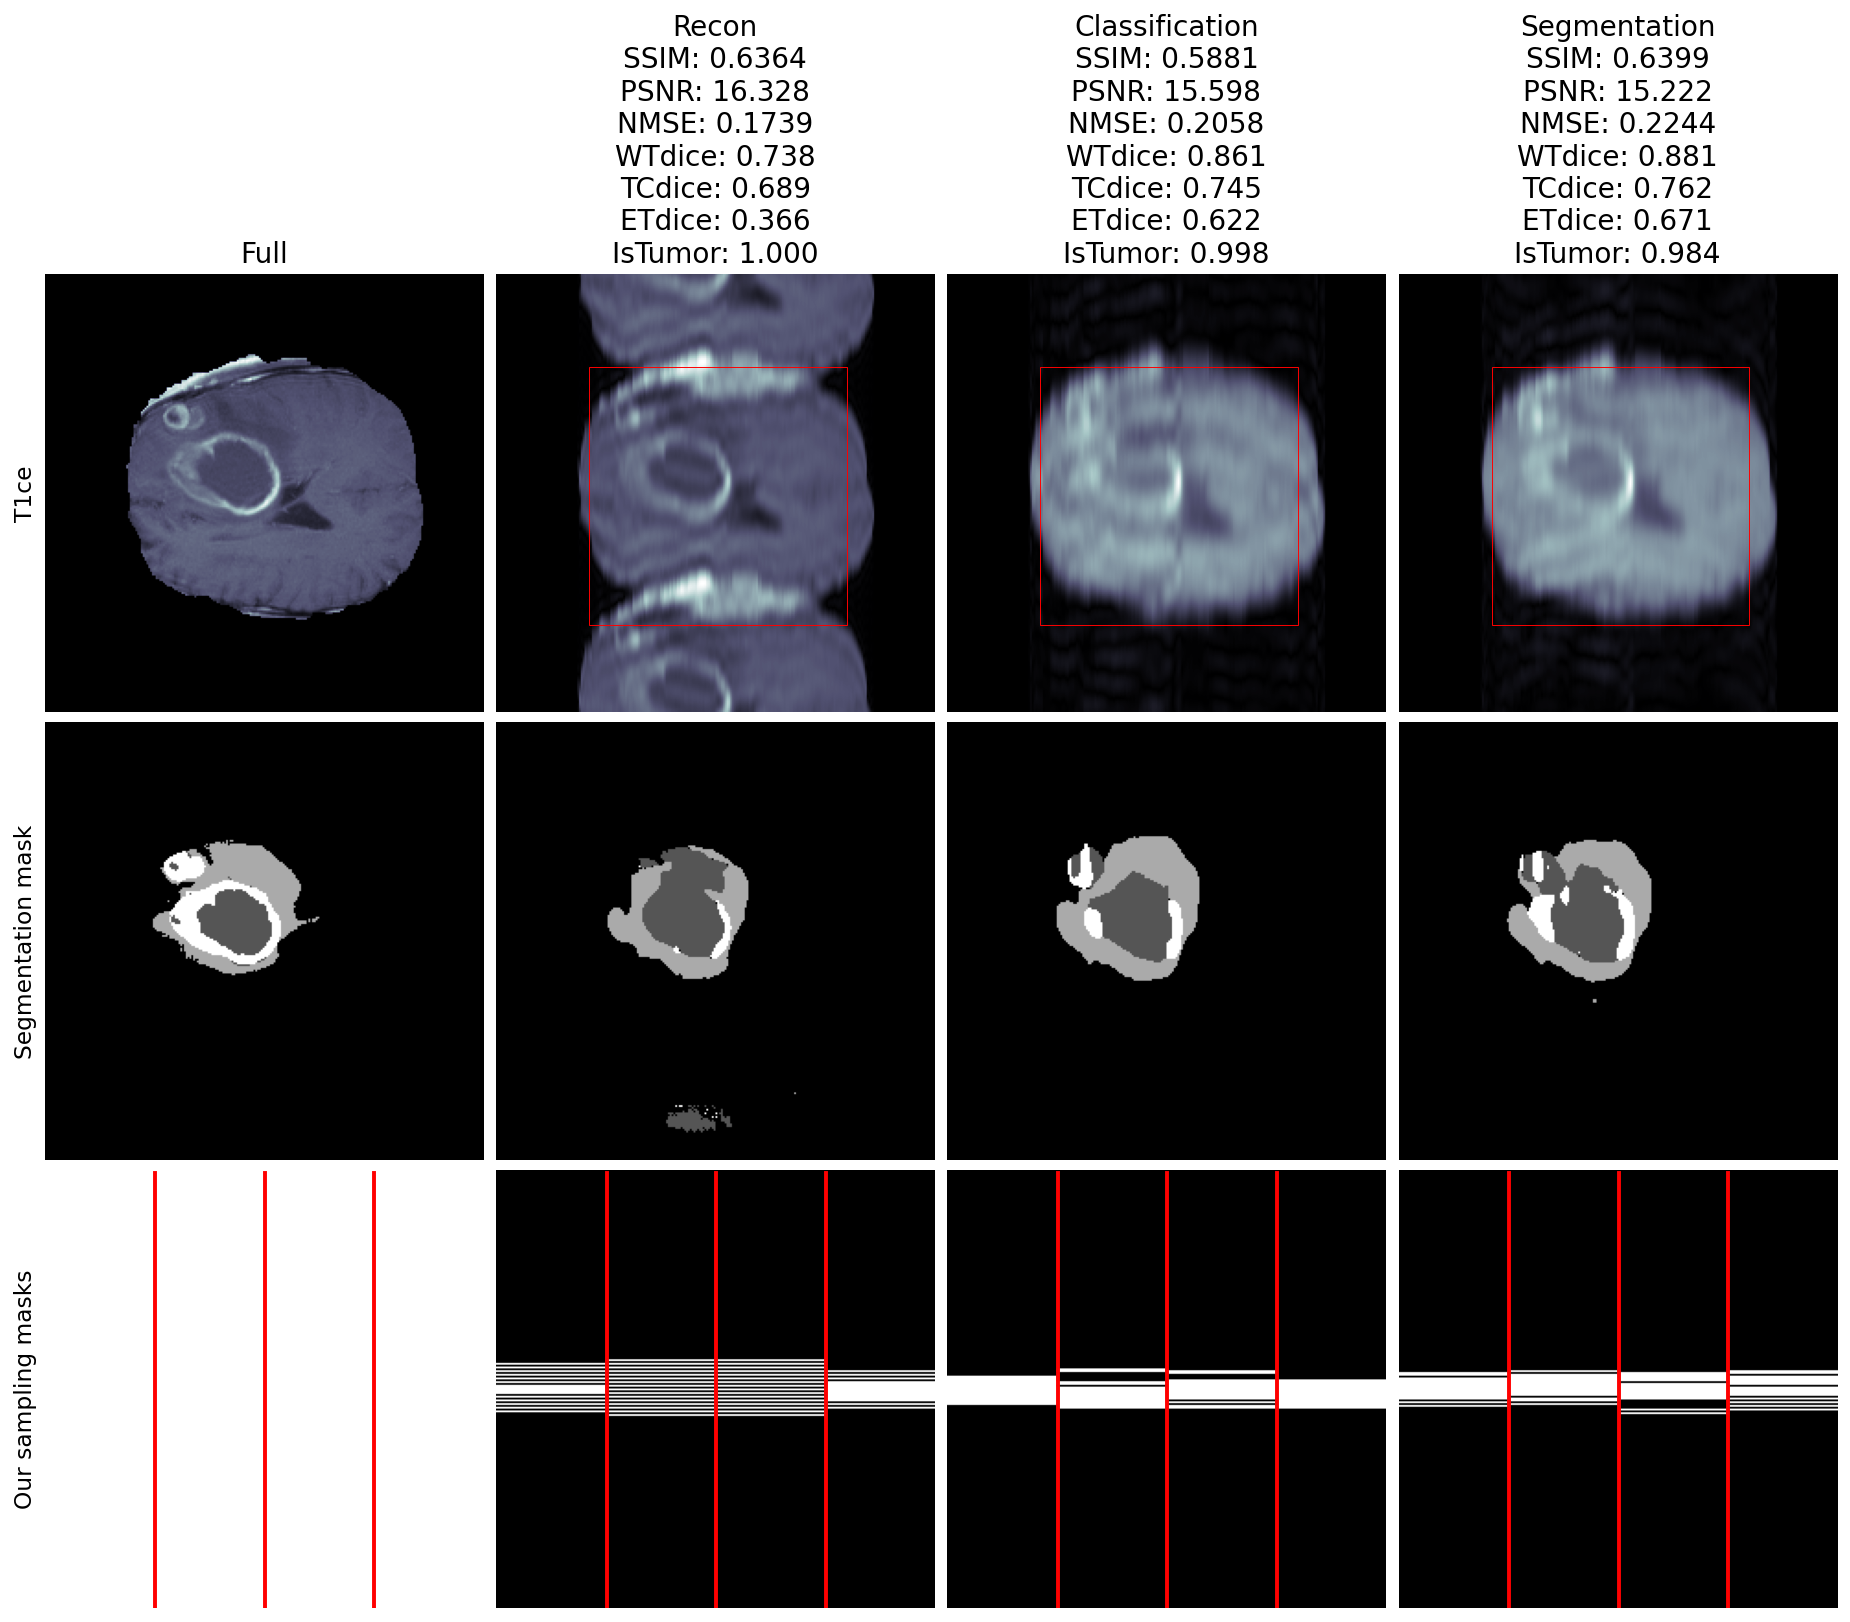

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(8*1.6,6*1.6), dpi=140, subplot_kw=dict(frameon=False, xticks=[], yticks=[]), gridspec_kw=None)

ax[0,0].imshow(img, cmap=plt.cm.bone)
ax[0,0].set_title('Full')
ax[0,1].imshow(img_recon, cmap=plt.cm.bone)
ax[0,1].add_patch(plt.matplotlib.patches.Rectangle((50, 50), 140, 140, linewidth=0.5, edgecolor='r', facecolor='none'))
scores = get_scores(img_recon, img, yp_recon, mask, cls_recon)
ax[0,1].set_title('Recon\n' + scores)
ax[0,2].imshow(img_clf, cmap=plt.cm.bone)
ax[0,2].add_patch(plt.matplotlib.patches.Rectangle((50, 50), 140, 140, linewidth=0.5, edgecolor='r', facecolor='none'))
scores = get_scores(img_clf, img, yp_clf, mask, cls_clf)
ax[0,2].set_title('Classification\n' + scores)
ax[0,3].imshow(img_seg, cmap=plt.cm.bone)
ax[0,3].add_patch(plt.matplotlib.patches.Rectangle((50, 50), 140, 140, linewidth=0.5, edgecolor='r', facecolor='none'))
scores = get_scores(img_seg, img, yp_seg, mask, cls_seg)
ax[0,3].set_title('Segmentation\n' + scores)

ax[1,0].imshow(mask[0, N], cmap=plt.cm.binary_r)
ax[1,1].imshow(logit2mask(yp_recon)[0, N], cmap=plt.cm.binary_r)
ax[1,2].imshow(logit2mask(yp_clf)[0, N], cmap=plt.cm.binary_r)
ax[1,3].imshow(logit2mask(yp_seg)[0, N], cmap=plt.cm.binary_r)

ax[2,0].imshow(torch.ones(240,240), cmap=plt.cm.binary)
ax[2,1].imshow(w2sampling(w_recon), cmap=plt.cm.binary_r)
ax[2,2].imshow(w2sampling(w_clf), cmap=plt.cm.binary_r)
ax[2,3].imshow(w2sampling(w_seg), cmap=plt.cm.binary_r)

for i in range(4):
    for j in range(3):
        ax[2,i].plot([60*(j+1),60*(j+1)],[1,239], 'r')

ax[0,0].set_ylabel(brats_image_map[C])
ax[1,0].set_ylabel('Segmentation mask')
ax[2,0].set_ylabel('Our sampling masks')

fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.03, hspace=0)
plt.savefig('brats-gallery-ex2.eps', bbox_inches = "tight")
plt.show()

torch.Size([238, 238])
torch.Size([238, 238])
torch.Size([238, 238])


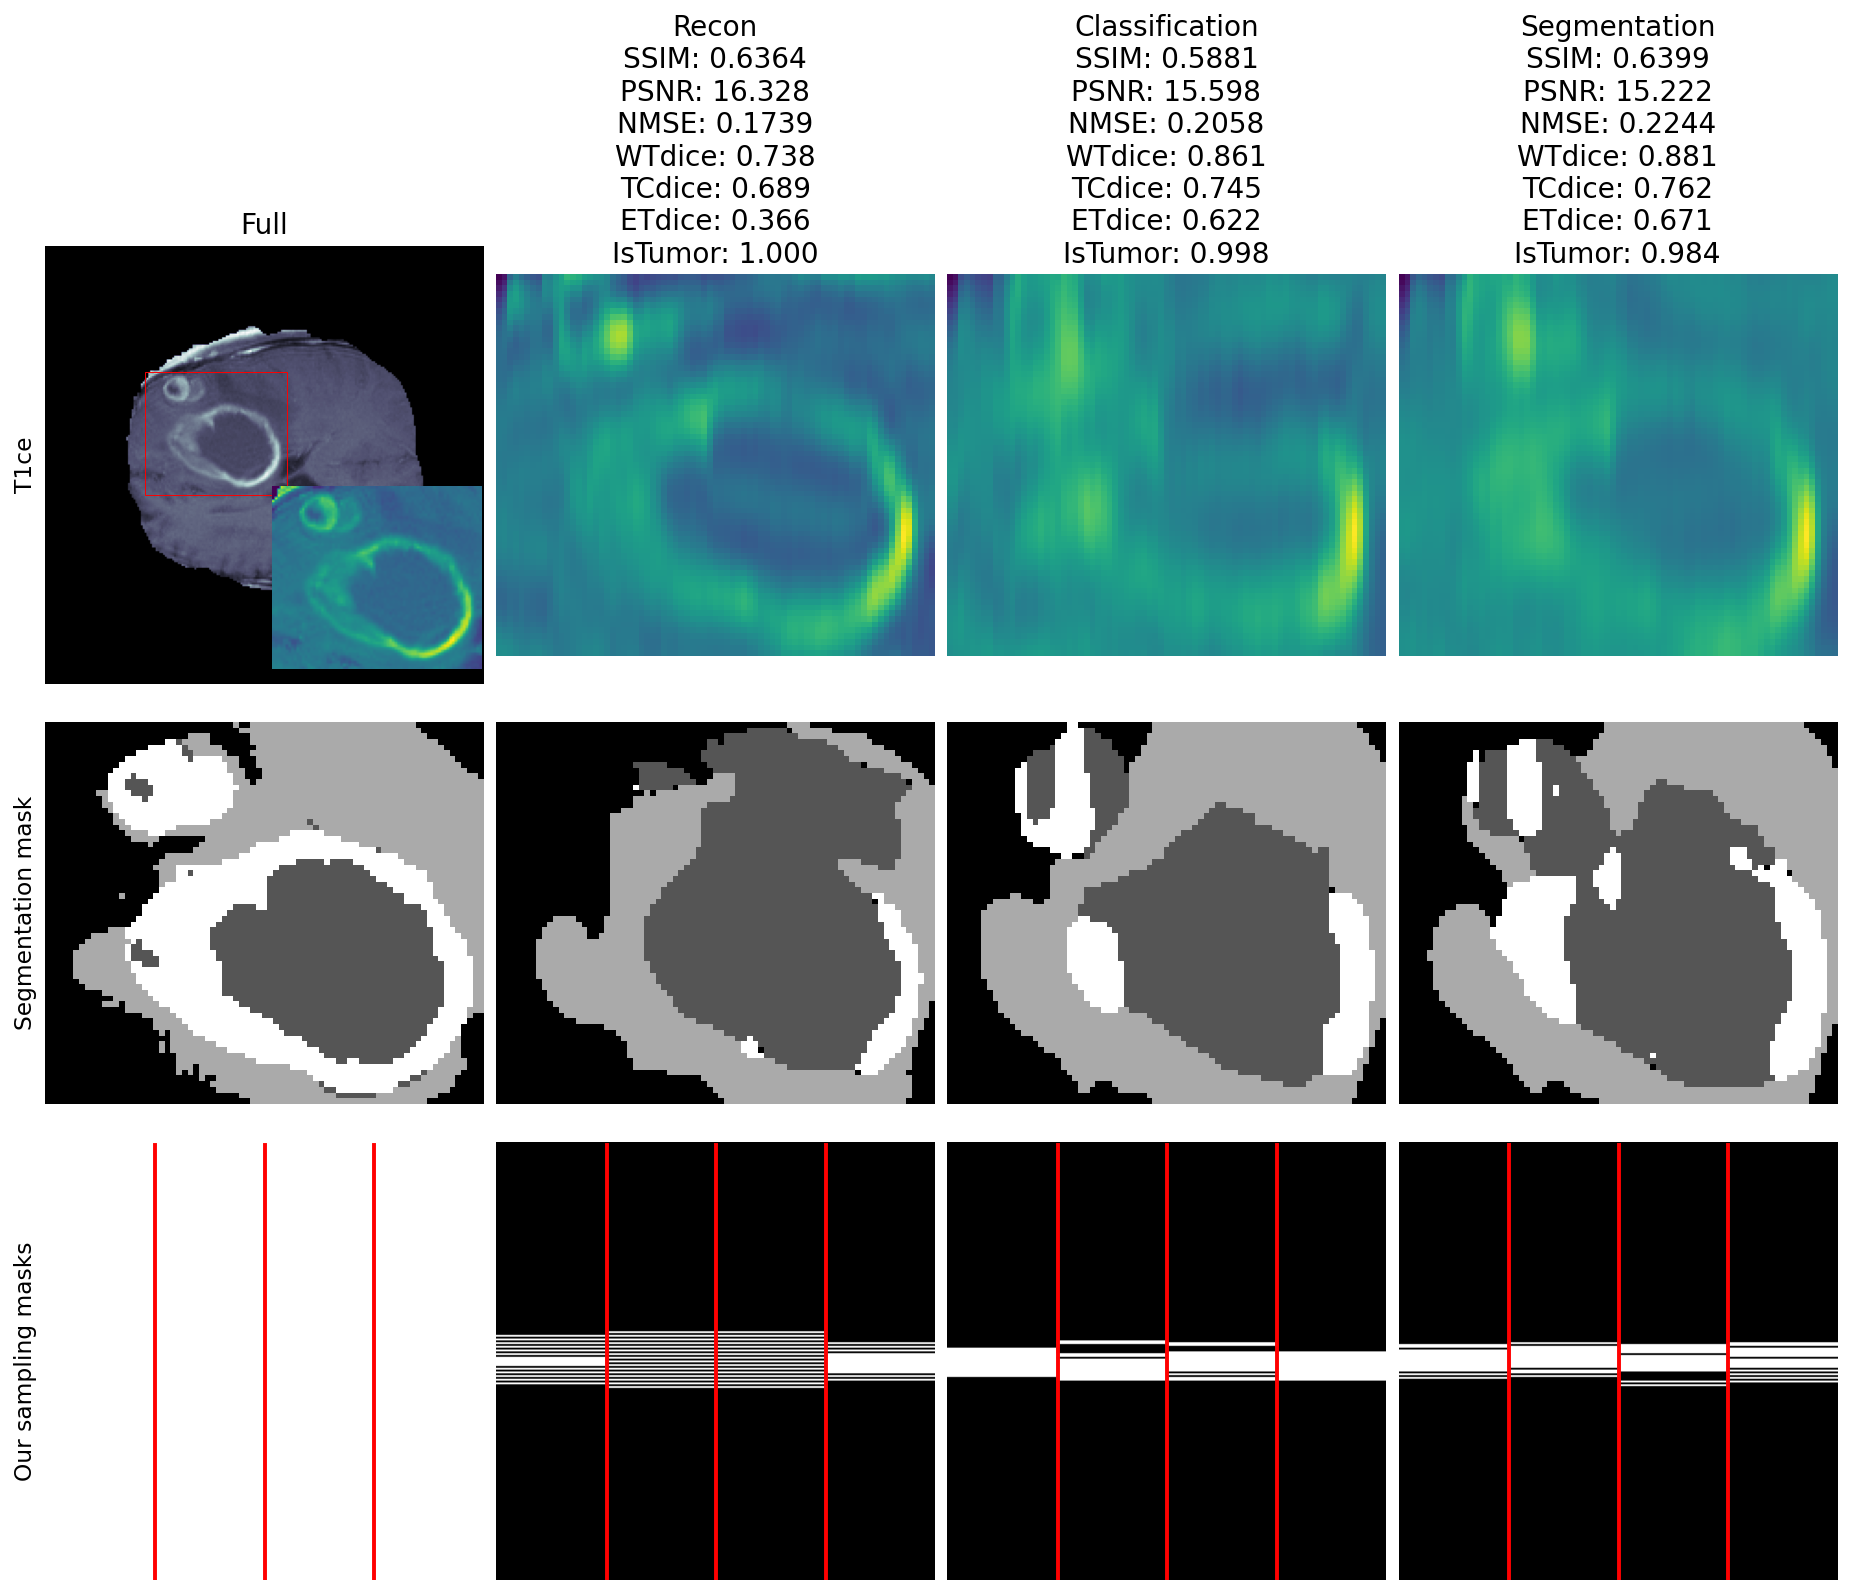

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(8*1.6,6*1.6), dpi=140, subplot_kw=dict(frameon=False, xticks=[], yticks=[]), gridspec_kw=None)

ax[0,0].imshow(img, cmap=plt.cm.bone)
ax[0,0].set_title('Full')
im = plt.matplotlib.offsetbox.OffsetImage(ax[0,0].images[0].get_array().data[68:135,54:131], zoom=1.4)
rect = plt.matplotlib.patches.Rectangle((54, 68), 131-54, 135-68, linewidth=0.5, edgecolor='r', facecolor='none')
im.image.axes = ax[0,0]
ab = plt.matplotlib.offsetbox.AnnotationBbox(
    im, (0, 0),
    xybox=(180., 180.),
    pad=0.2,
    frameon=False,
)
ax[0,0].add_artist(ab)
ax[0,0].add_patch(rect)

ax[0,1].imshow(img_recon[68:135,54:131], cmap=plt.cm.viridis)
# ax[0,1].add_patch(plt.matplotlib.patches.Rectangle((50, 50), 140, 140, linewidth=0.5, edgecolor='r', facecolor='none'))
scores = get_scores(img_recon, img, yp_recon, mask, cls_recon)
ax[0,1].set_title('Recon\n' + scores)

ax[0,2].imshow(img_clf[68:135,54:131], cmap=plt.cm.viridis)
# ax[0,2].add_patch(plt.matplotlib.patches.Rectangle((50, 50), 140, 140, linewidth=0.5, edgecolor='r', facecolor='none'))
scores = get_scores(img_clf, img, yp_clf, mask, cls_clf)
ax[0,2].set_title('Classification\n' + scores)

ax[0,3].imshow(img_seg[68:135,54:131], cmap=plt.cm.viridis)
# ax[0,3].add_patch(plt.matplotlib.patches.Rectangle((50, 50), 140, 140, linewidth=0.5, edgecolor='r', facecolor='none'))
scores = get_scores(img_seg, img, yp_seg, mask, cls_seg)
ax[0,3].set_title('Segmentation\n' + scores)

ax[1,0].imshow(mask[0, N][68:135,54:131], cmap=plt.cm.binary_r)
ax[1,1].imshow(logit2mask(yp_recon)[0, N][68:135,54:131], cmap=plt.cm.binary_r)
ax[1,2].imshow(logit2mask(yp_clf)[0, N][68:135,54:131], cmap=plt.cm.binary_r)
ax[1,3].imshow(logit2mask(yp_seg)[0, N][68:135,54:131], cmap=plt.cm.binary_r)

ax[2,0].imshow(torch.ones(240,240), cmap=plt.cm.binary)
ax[2,1].imshow(w2sampling(w_recon), cmap=plt.cm.binary_r)
ax[2,2].imshow(w2sampling(w_clf), cmap=plt.cm.binary_r)
ax[2,3].imshow(w2sampling(w_seg), cmap=plt.cm.binary_r)

for i in range(4):
    for j in range(3):
        ax[2,i].plot([60*(j+1),60*(j+1)],[1,239], 'r')

ax[0,0].set_ylabel(brats_image_map[C])
ax[1,0].set_ylabel('Segmentation mask')
ax[2,0].set_ylabel('Our sampling masks')

fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.03, hspace=0)
plt.savefig('brats-gallery-v2-ex2.eps', bbox_inches = "tight")
plt.show()

In [15]:
img[45:-45,45:-45].shape

torch.Size([148, 148])

In [16]:
148 * 0.5 // 2

37.0

In [17]:
37 * 2

74

In [36]:
def add_subplot_axes(ax,rect):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]
    subax = fig.add_axes([x,y,width,height], frame_on=False, xticks=[], yticks=[])
#     x_labelsize = subax.get_xticklabels()[0].get_size()
#     y_labelsize = subax.get_yticklabels()[0].get_size()
#     x_labelsize *= rect[2]**0.5
#     y_labelsize *= rect[3]**0.5
#     subax.xaxis.set_tick_params(labelsize=x_labelsize)
#     subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

In [64]:
def get_scores(pred, gt, yp_sg, mask_sg, cls_sg):
    print(pred.shape)
    displ = 50
    pred = pred[displ:-displ,displ:-displ]
    gt = gt[displ:-displ,displ:-displ]
    ssim_val = pt_ssim(pred[None], gt[None]).item()
    psnr_val = pt_psnr(pred, gt).item()
    nmse_val = pt_nmse(pred, gt).item()
    dice_wt, dice_tc, dice_et = dice_coeff_3d_classes(mask_sg, yp_sg)
#     return 'SSIM: %.4f\nPSNR: %.3f\nNMSE: %.4f\nWTdice: %.3f\nTCdice: %.3f\nETdice: %.3f\nIsTumor: %.3f' % (
#         ssim_val, psnr_val, nmse_val, dice_wt, dice_tc, dice_et, cls_sg[-1].item()
#     )
    return {'ssim': ssim_val, 'psnr': psnr_val, 'nmse': nmse_val, 'wt': dice_wt, 'tc': dice_tc, 'et': dice_et, 'p': cls_sg[-1].item()}

def logit2mask(yp):
    probas = F.softmax(yp, dim=0)
    probas = (probas > 0.5).long()
    pmask = torch.zeros_like(mask)
    pmask[0] = probas[1] * 1 + probas[2] * 2 + probas[3] * 3
    return pmask

def w2sampling(_w):
    ssm = torch.zeros(240, 240)
    for i in range(4):
        ssm[:, 60*i:60*(i+1)] = _w[i][:, None]
        # ssm[60*i:60*(i+1)] = _w[i]
    return ssm

# torch.save([img, img_recon, img_clf, img_seg, yp_recon, yp_clf, yp_seg, cls_recon, cls_clf, cls_seg, mask], 'plot_buffer_1.pt')
img, img_recon, img_clf, img_seg, yp_recon, yp_clf, yp_seg, cls_recon, cls_clf, cls_seg, mask = torch.load('plot_buffer_1.pt')

C = 2
N = 95
displ = 1

torch.Size([238, 238])
torch.Size([238, 238])
torch.Size([238, 238])
torch.Size([238, 238])
torch.Size([238, 238])
torch.Size([238, 238])


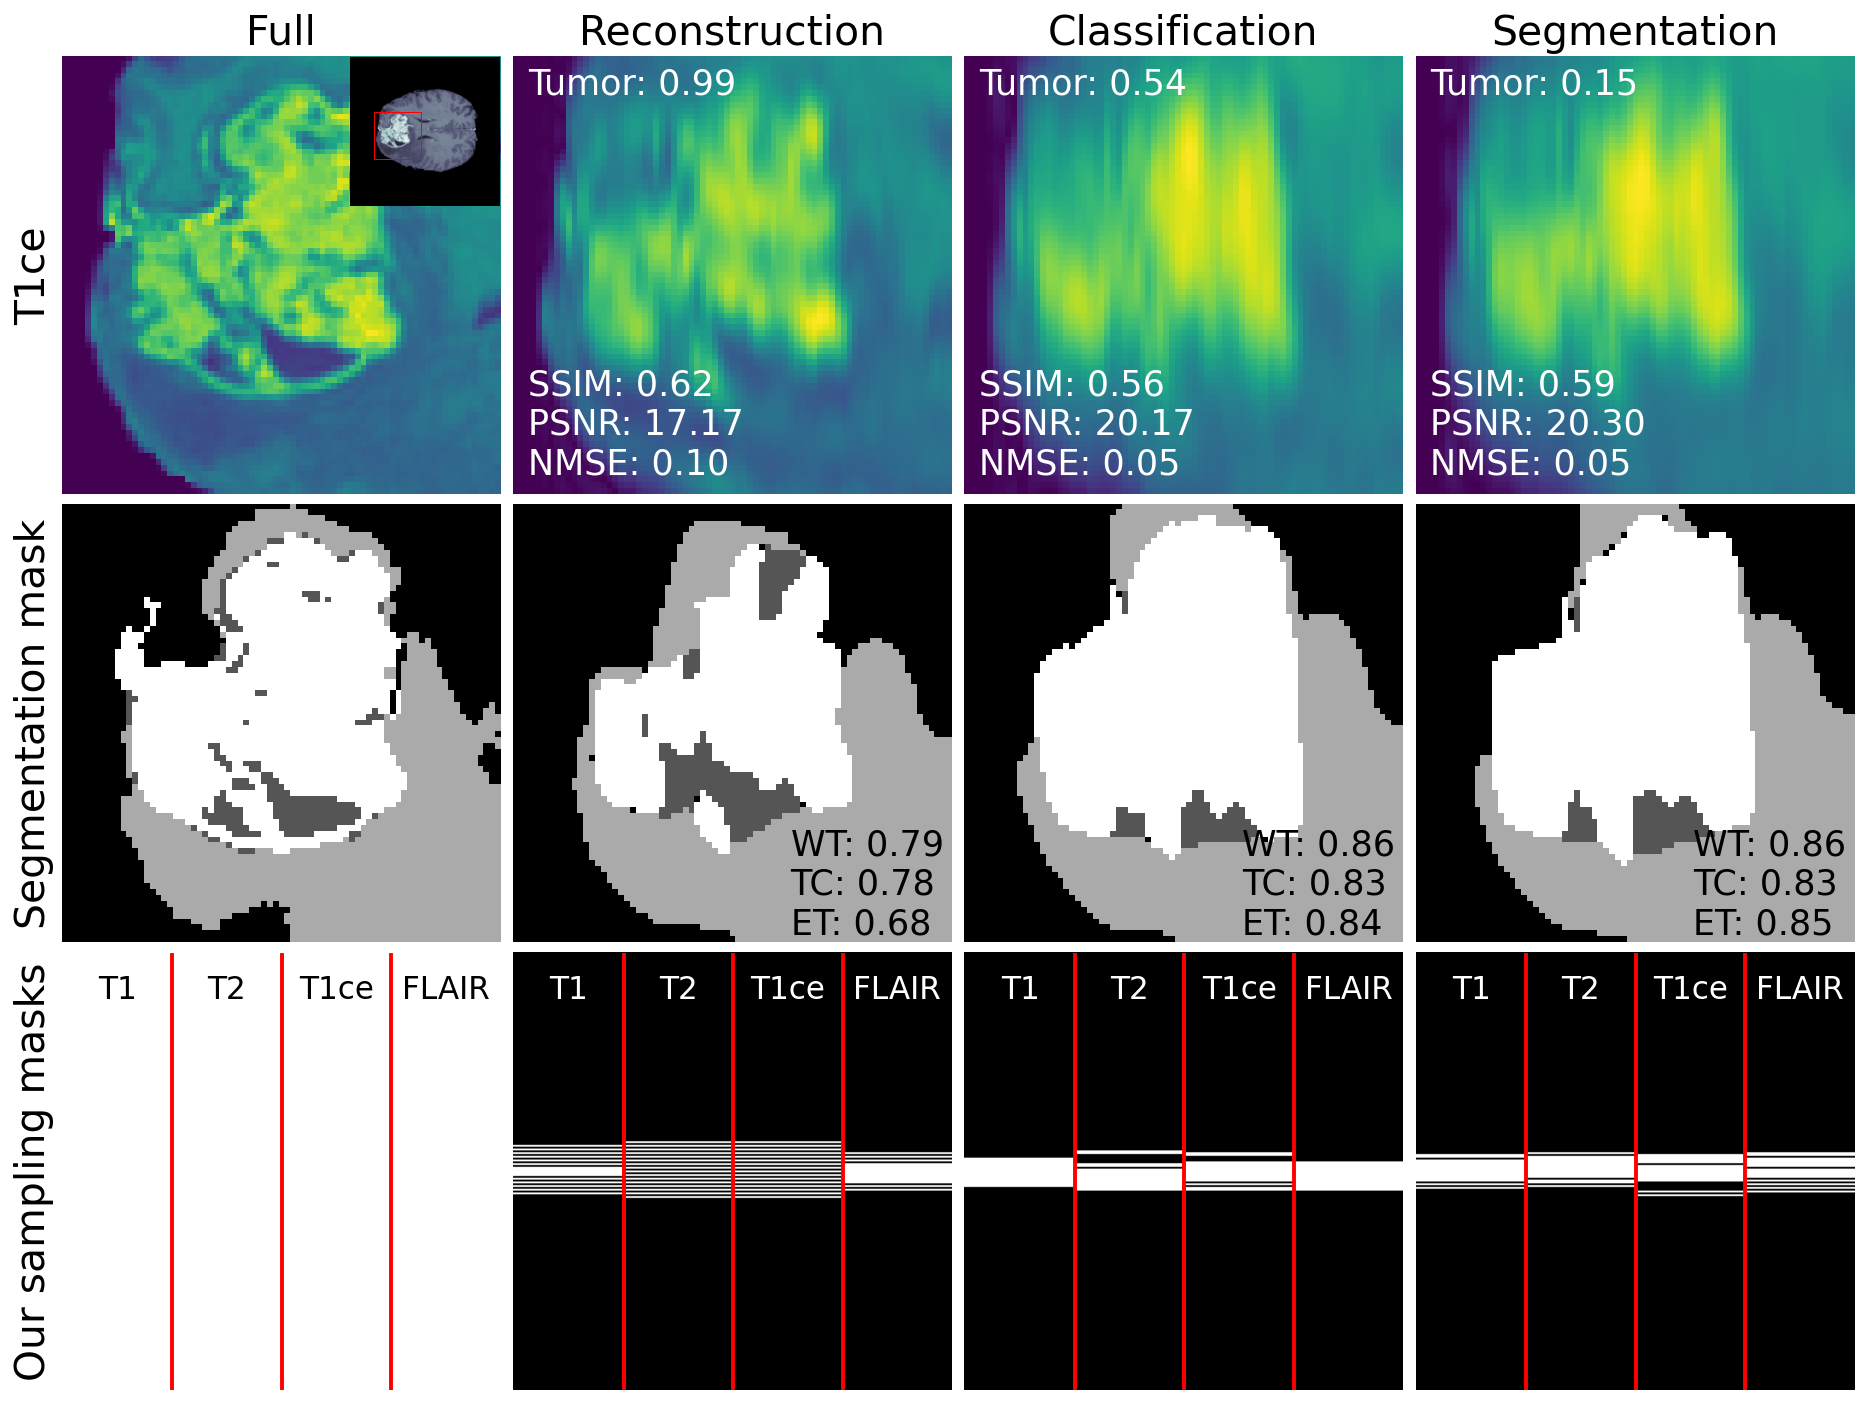

In [102]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(8*1.6,6*1.6), dpi=140, subplot_kw=dict(frameon=False, xticks=[], yticks=[]), gridspec_kw=None)

ax[0,0].imshow(img[87:87+75,37:37+75], cmap=plt.cm.viridis)
ax[0,0].set_title('Full', fontsize=21)
ax_extra = add_subplot_axes(ax[0,0], [0.21,1.02,0.5,0.5])
ax_extra.imshow(img, cmap=plt.cm.bone)
# rect = plt.matplotlib.patches.Rectangle((54, 68), 131-54, 135-68, linewidth=0.5, edgecolor='r', facecolor='none')
rect = plt.matplotlib.patches.Rectangle((37, 87), 75, 75, linewidth=0.5, edgecolor='r', facecolor='none')
ax_extra.add_patch(rect)

ax[0,1].imshow(img_recon[87:87+75,37:37+75], cmap=plt.cm.viridis)
scores = get_scores(img_recon, img, yp_recon, mask, cls_recon)
ax[0,1].text(2, 71, "SSIM: %.2f\nPSNR: %.2f\nNMSE: %.2f" % (scores['ssim'], scores['psnr'], scores['nmse']), c='w', fontsize=18)
ax[0,1].text(2, 6, "Tumor: %.2f" % scores['p'], c='w', fontsize=18)
ax[0,1].set_title('Reconstruction', fontsize=21)

ax[0,2].imshow(img_clf[87:87+75,37:37+75], cmap=plt.cm.viridis)
scores = get_scores(img_clf, img, yp_clf, mask, cls_clf)
ax[0,2].text(2, 71, "SSIM: %.2f\nPSNR: %.2f\nNMSE: %.2f" % (scores['ssim'], scores['psnr'], scores['nmse']), c='w', fontsize=18)
ax[0,2].text(2, 6, "Tumor: %.2f" % scores['p'], c='w', fontsize=18)
ax[0,2].set_title('Classification', fontsize=21)

ax[0,3].imshow(img_seg[87:87+75,37:37+75], cmap=plt.cm.viridis)
scores = get_scores(img_seg, img, yp_seg, mask, cls_seg)
ax[0,3].text(2, 71, "SSIM: %.2f\nPSNR: %.2f\nNMSE: %.2f" % (scores['ssim'], scores['psnr'], scores['nmse']), c='w', fontsize=18)
ax[0,3].text(2, 6, "Tumor: %.2f" % scores['p'], c='w', fontsize=18)
ax[0,3].set_title('Segmentation', fontsize=21)

ax[1,0].imshow(mask[0, N][87:87+75,37:37+75], cmap=plt.cm.binary_r)
ax[1,1].imshow(logit2mask(yp_recon)[0, N][87:87+75,37:37+75], cmap=plt.cm.binary_r)
scores = get_scores(img_recon, img, yp_recon, mask, cls_recon)
ax[1,1].text(47, 73, "WT: %.2f\nTC: %.2f\nET: %.2f" % (scores['wt'], scores['tc'], scores['et']), c='k', fontsize=18)
ax[1,2].imshow(logit2mask(yp_clf)[0, N][87:87+75,37:37+75], cmap=plt.cm.binary_r)
scores = get_scores(img_clf, img, yp_clf, mask, cls_clf)
ax[1,2].text(47, 73, "WT: %.2f\nTC: %.2f\nET: %.2f" % (scores['wt'], scores['tc'], scores['et']), c='k', fontsize=18)
ax[1,3].imshow(logit2mask(yp_seg)[0, N][87:87+75,37:37+75], cmap=plt.cm.binary_r)
scores = get_scores(img_seg, img, yp_seg, mask, cls_seg)
ax[1,3].text(47, 73, "WT: %.2f\nTC: %.2f\nET: %.2f" % (scores['wt'], scores['tc'], scores['et']), c='k', fontsize=18)

ax[2,0].imshow(torch.ones(240,240), cmap=plt.cm.binary)
ax[2,1].imshow(w2sampling(w_recon), cmap=plt.cm.binary_r)
ax[2,2].imshow(w2sampling(w_clf), cmap=plt.cm.binary_r)
ax[2,3].imshow(w2sampling(w_seg), cmap=plt.cm.binary_r)

for i in range(4):
    for j in range(3):
        ax[2,i].text(60*(j+1) - 30, 20, brats_image_map[j], c='k' if i==0 else 'w', ha='center', va='center', fontsize=16)
        ax[2,i].plot([60*(j+1),60*(j+1)],[1,239], 'r')
    ax[2,i].text(60*(3+1) - 30, 20, brats_image_map[3], c='k' if i==0 else 'w', ha='center', va='center', fontsize=16)

ax[0,0].set_ylabel(brats_image_map[C], fontsize=21)
ax[1,0].set_ylabel('Segmentation mask', fontsize=21)
ax[2,0].set_ylabel('Our sampling masks', fontsize=21)

fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.03, hspace=0)
plt.savefig('brats-gallery-v3-ex3.eps', bbox_inches = "tight")
plt.show()

(-0.5, 239.5, 239.5, -0.5)

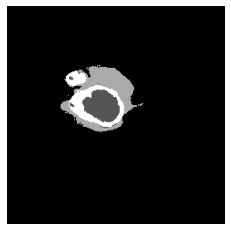

In [16]:
plt.imshow(mask[0, N], cmap=plt.cm.binary_r)
plt.axis('off')

(-0.5, 239.5, 239.5, -0.5)

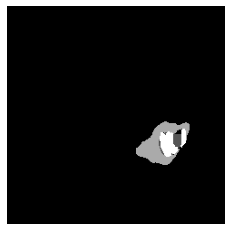

In [15]:
plt.imshow(logit2mask(yp_seg)[0, N], cmap=plt.cm.binary_r)
plt.axis('off')

(-0.5, 237.5, 237.5, -0.5)

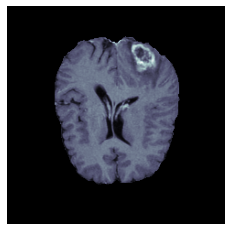

In [19]:
plt.imshow(img.rot90(), cmap=plt.cm.bone)
plt.axis('off')

(-0.5, 237.5, 237.5, -0.5)

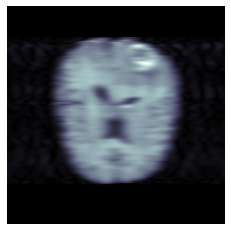

In [27]:
plt.imshow(img_seg.rot90(), cmap=plt.cm.bone)
plt.axis('off')

(-0.5, 239.5, 239.5, -0.5)

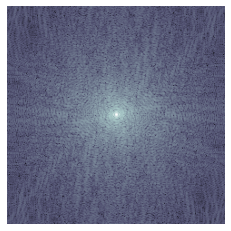

In [25]:
plt.imshow((ks.abs() + 1e-11).log()[C, N].rot90(), cmap=plt.cm.bone)
plt.axis('off')

(-0.5, 239.5, 239.5, -0.5)

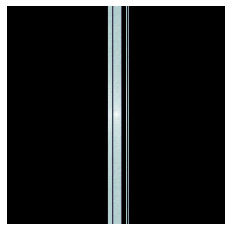

In [26]:
plt.imshow(((ks * w_seg.unsqueeze(2).unsqueeze(1)).abs() + 1e-11).log()[C, N].rot90(), cmap=plt.cm.bone)
plt.axis('off')